In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import pandas as pd
import numpy as np

## Making a corner plot
Our samples more generally can be shown using a corner/triangle plot.  The `subtriangle()` method below is a very thin wrapper on Dan Foreman-Mackey's **corner.py** code.  We'll overplot the MAP value as blue lines.

In [2]:
import prospect.io.read_results as reader
#results_type = "dynesty" # | "emcee"
results_type = "emcee"

result, obs, _ = reader.results_from("2020oi_HSTpreExplosion_{}_mcmc_VeryLongRun_RefinedGrid.h5".format(results_type), dangerous=False)


In [3]:
np.shape(result['chain'])

(128, 7500, 3)

In [4]:
np.shape(result['chain'][:,:,0])

(128, 7500)

In [5]:
mass = result['chain'][:,:,0].flatten()
Zsol = result['chain'][:,:,1].flatten()
Age = result['chain'][:,:,2].flatten()

In [6]:
DF_margMass = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/derived_data/prospectorGridSearch_marginalizedMass.csv")
DF_margZ = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/derived_data/prospectorGridSearch_marginalizedZ.csv")
DF_margAge = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/derived_data/prospectorGridSearch_marginalizedAge.csv")

In [7]:
DF_margZ['logMass'] = np.log10(DF_margZ['Mass'])
DF_margAge['logMass'] = np.log10(DF_margAge['Mass'])

In [8]:
def subcorner(results, showpars=None, truths=None,
              start=0, thin=1, chains=slice(None),
              logify=["mass", "tau"], **kwargs):
    """Make a triangle plot of the (thinned, latter) samples of the posterior
    parameter space.  Optionally make the plot only for a supplied subset of
    the parameters.

    :param showpars: (optional)
        List of string names of parameters to include in the corner plot.

    :param truths: (optional)
        List of truth values for the chosen parameters.

    :param start: (optional, default: 0)
        The iteration number to start with when drawing samples to plot.

    :param thin: (optional, default: 1)
        The thinning of each chain to perform when drawing samples to plot.

    :param chains: (optional)
        If results are from an ensemble sampler, setting `chain` to an integer
        array of walker indices will cause only those walkers to be used in
        generating the plot.  Useful for emoving stuck walkers.

    :param kwargs:
        Remaining keywords are passed to the ``corner`` plotting package.

    :param logify:
        A list of parameter names to plot in `log10(parameter)` instead of
        `parameter`
    """
    try:
        import corner as triangle
    except(ImportError):
        import triangle
    except:
        raise ImportError("Please install the `corner` package.")

    # pull out the parameter names and flatten the thinned chains
    # Get parameter names
    try:
        parnames = np.array(results['theta_labels'], dtype='U20')
    except(KeyError):
        parnames = np.array(results['model'].theta_labels())
    # Restrict to desired parameters
    if showpars is not None:
        ind_show = np.array([parnames.tolist().index(p) for p in showpars])
        parnames = parnames[ind_show]
    else:
        ind_show = slice(None)

    # Get the arrays we need (trace, wghts)
    trace = results['chain'][..., ind_show]
    if trace.ndim == 2:
        trace = trace[None, :]
    trace = trace[chains, start::thin, :]
    wghts = results.get('weights', None)
    if wghts is not None:
        wghts = wghts[start::thin]
    samples = trace.reshape(trace.shape[0] * trace.shape[1], trace.shape[2])

    # logify some parameters
    xx = samples.copy()
    if truths is not None:
        xx_truth = np.array(truths).copy()
    else:
        xx_truth = None
    for p in logify:
        if p in parnames:
            idx = parnames.tolist().index(p)
            xx[:, idx] = np.log10(xx[:, idx])
            parnames[idx] = "log({})".format(parnames[idx])
            if truths is not None:
                xx_truth[idx] = np.log10(xx_truth[idx])

    # mess with corner defaults
    corner_kwargs = {"plot_datapoints": False, "plot_density": False,
                     "fill_contours": True, "show_titles": True}
    corner_kwargs.update(kwargs)

    fig = triangle.corner(xx, labels=parnames, truths=xx_truth,
                          quantiles=[0.], weights=wghts, **corner_kwargs)

    return fig


<ipython-input-9-faa52eba1c25>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys = np.array([DF_margAge['logZ/Zsol'], DF_margZ['Age'], DF_margMass['Age']])
<ipython-input-9-faa52eba1c25>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xs = np.array([DF_margAge['logMass'], DF_margZ['logMass'], DF_margMass['logZ/Zsol']])
<ipython-input-9-faa52eba1c25>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant 

<Figure size 720x504 with 0 Axes>

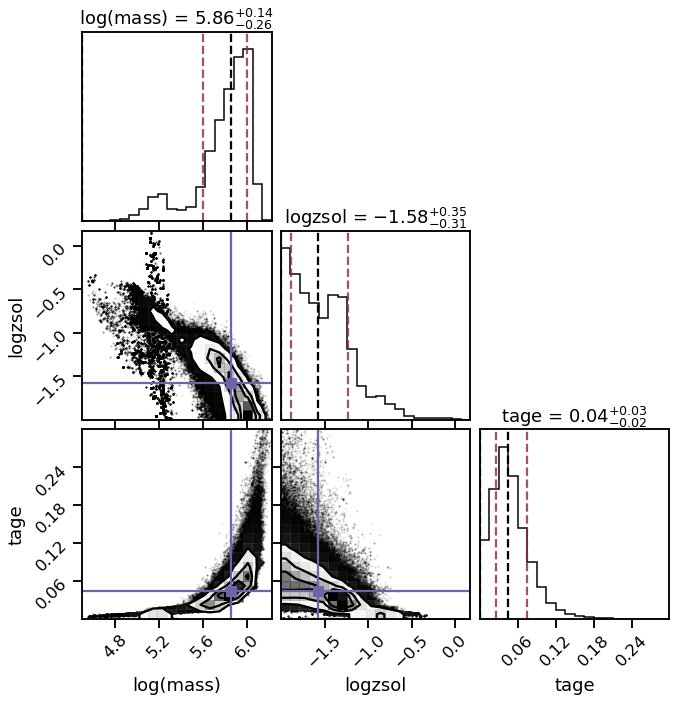

In [9]:
# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    thin = 1
else:
    theta_max = result["chain"][imax, :]
    thin = 1
plt.figure(figsize=(10,7))
sns.set_context("talk")

figure = subcorner(result, plot_datapoints=True, start=0, thin=thin,
                             fig=subplots(3,3,figsize=(10,10))[0], fill_contours=False, plot_density=True)

ndim = 3
value1 = np.array([5.86-0.26, -1.58-0.31, 0.045-0.02])
value2 = np.array([5.86, -1.58, 0.045])
value3 = np.array([5.86+0.14, -1.58+0.35, 0.045+0.03])
value4 = np.array([5.86, -1.58, 0.045])
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
#for i in range(ndim):
#    ax = axes[i, i]
#    ax.axvline(value1[i], color="g")
 #   ax.axvline(value2[i], color="r")
    
#plt.savefig("CornerPlot_EmceeResults_StarBurst.png",dpi=200, bbox_inches='tight')

#1. logZsol vs logmass
#2. tage vs logmass
#3. tage vs logZsol

ys = np.array([DF_margAge['logZ/Zsol'], DF_margZ['Age'], DF_margMass['Age']])
xs = np.array([DF_margAge['logMass'], DF_margZ['logMass'], DF_margMass['logZ/Zsol']])
zs = np.array([DF_margAge['Prob'], DF_margZ['Prob'], DF_margMass['Prob']])

#top left, bottom left, bottom right
i = 0
# Loop over the histograms
#set xlim and ylim
xlimsL = np.array([4.5, 4.5, -2.0])
xlimsH = np.array([6.5, 6.5, 0.0])

ylimsL = np.array([-2.0, 0.001, 0.001])
ylimsH = np.array([0.0, 0.2, 0.2])

for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value4[xi], color="#7262A7")
        ax.axhline(value4[yi], color="#7262A7")
        ax.plot([value4[xi]], [value4[yi]], marker='s',c="#7262A7", ms=10, zorder=100)

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], linestyle='--', alpha=0.8, c='#932733')
    ax.axvline(value3[i], linestyle='--', alpha=0.8, c='#932733')
    ax.axvline(value4[i], linestyle='--', alpha=1, c='k')

   # if i==2:
    #    ax.axvspan(10**(6.58-0.06)/1.e9, 10**(6.58+0.06)/1.e9, alpha=0.8, color='#6BE3CF')
    #    ax.axvspan(10**(7.33-0.06)/1.e9, 10**(7.33+0.06)/1.e9, alpha=0.8, color='#6BE3CF')
    #    ax.axvspan(10**(7.61-0.06)/1.e9, 10**(7.61+0.06)/1.e9, alpha=0.8, color='#6BE3CF')
    #    ax.axvspan(10**(7.78-0.06)/1.e9, 10**(7.78+0.06)/1.e9, alpha=0.8, color='#6BE3CF')

#        Best estimate from Arm 1, rotation 1 is log10(Age) = 6.58 +/- 0.06 years, or 3.79 Myr.
#Best estimate from Arm 2, rotation 1 is log10(Age) = 7.33 +/- 0.06 years, or 21.54 Myr.
#Best estimate from Arm 1, rotation 2 is log10(Age) = 7.61 +/- 0.06 years, or 40.75 Myr.
#Best estimate from Arm 2, rotation 2 is log10(Age) = 7.78 +/- 0.06 years, or 60.44 Myr.
plt.savefig("/Users/alexgagliano/Documents/Research/2020oi/scripts/prospector/2020oi_modeling/CornerPlot_EmceeResults_SpiralAges.png",dpi=200, bbox_inches='tight')

<ipython-input-12-01ab62ba3367>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys = np.array([DF_margAge['logZ/Zsol'], DF_margZ['Age'], DF_margMass['Age']])
<ipython-input-12-01ab62ba3367>:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xs = np.array([DF_margAge['logMass'], DF_margZ['logMass'], DF_margMass['logZ/Zsol']])
<ipython-input-12-01ab62ba3367>:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mea

<Figure size 720x504 with 0 Axes>

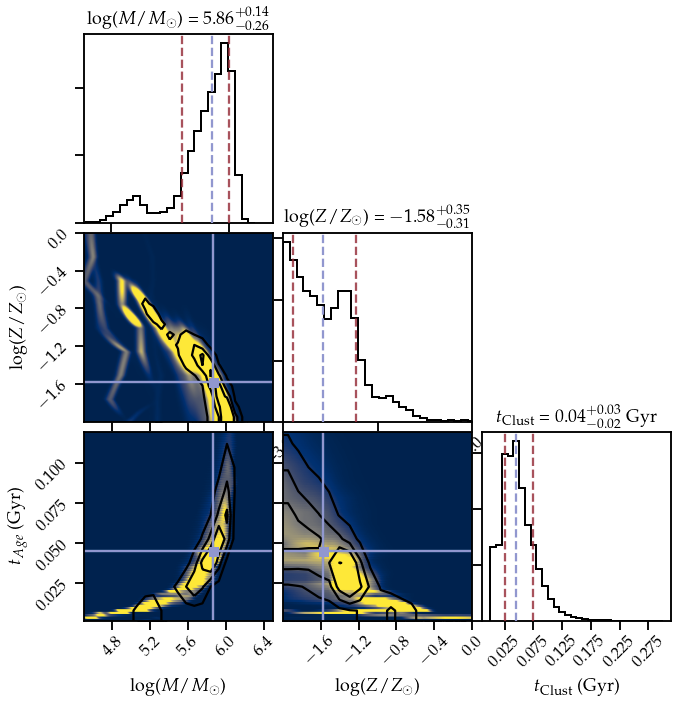

In [12]:
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    thin = 1
else:
    theta_max = result["chain"][imax, :]
    thin = 1
plt.figure(figsize=(10,7))
sns.set_context("talk")

figure = reader.subcorner(result, plot_datapoints=True, start=0, thin=thin, truths=[10**5.86, -1.58, 0.045], 
                             fig=subplots(3,3,figsize=(10,10))[0], fill_contours=False, plot_density=True)

ndim = 3
value1 = np.array([5.86-0.26, -1.58-0.31, 0.045-0.02])
value2 = np.array([5.86, -1.58, 0.045])
value3 = np.array([5.86+0.14, -1.58+0.35, 0.045+0.03])
value4 = np.array([5.86, -1.58, 0.045])
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
#for i in range(ndim):
#    ax = axes[i, i]
#    ax.axvline(value1[i], color="g")
 #   ax.axvline(value2[i], color="r")
    
#plt.savefig("CornerPlot_EmceeResults_StarBurst.png",dpi=200, bbox_inches='tight')

#1. logZsol vs logmass
#2. tage vs logmass
#3. tage vs logZsol

ys = np.array([DF_margAge['logZ/Zsol'], DF_margZ['Age'], DF_margMass['Age']])
xs = np.array([DF_margAge['logMass'], DF_margZ['logMass'], DF_margMass['logZ/Zsol']])
zs = np.array([DF_margAge['Prob'], DF_margZ['Prob'], DF_margMass['Prob']])

marginals = [np.log10(mass), Zsol, Age]

#top left, bottom left, bottom right
i = 0
# Loop over the histograms
#set xlim and ylim
xlimsL = np.array([4.5, 4.5, -2.0])
xlimsH = np.array([6.5, 6.5, 0.0])

ylimsL = np.array([-2.0, 0.001, 0.001])
ylimsH = np.array([0.0, 0.12, 0.12])

soln_color = '#9197CF'
#cmap = sns.color_palette("light:cividis_r", as_cmap=True)
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
#        ax.clear()
#        ax.text(value1[xi], value1[yi], '%i'%i)
        #crop the data 
        tempX = xs[i][(xs[i] < xlimsH[i]) & (xs[i] >xlimsL[i])]
        tempY = ys[i][(xs[i] < xlimsH[i]) & (xs[i] >xlimsL[i])]
        tempZ = zs[i][(xs[i] < xlimsH[i]) & (xs[i] >xlimsL[i])]
   
        tempX_plot = tempX[(tempY < ylimsH[i]) & (tempY >ylimsL[i])]
        tempY_plot = tempY[(tempY < ylimsH[i]) & (tempY >ylimsL[i])]
        tempZ_plot = tempZ[(tempY < ylimsH[i]) & (tempY >ylimsL[i])]

        low = np.nanmin(-tempZ)
        high = np.nanmax(-tempZ)

        if i==2:
            sns.scatterplot(x=tempX_plot, y=tempY_plot, hue=-tempZ_plot/np.nanmedian(tempZ_plot), ax=ax, hue_norm=(-150, 0), legend=False, s=20, edgecolor=None, alpha=1.0, palette='cividis_r');
        elif i==0:
            sns.scatterplot(x=tempX_plot, y=tempY_plot, hue=-tempZ_plot/np.nanmedian(tempZ_plot), ax=ax, hue_norm=(-2000, 0), legend=False, s=20, edgecolor=None, alpha=1.0, palette='cividis_r');
        else:
            sns.scatterplot(x=tempX_plot, y=tempY_plot, hue=-tempZ_plot/np.nanmax(tempZ_plot), ax=ax, hue_norm=(-0.2, 0), legend=False, s=20, edgecolor=None, alpha=1.0, palette='cividis_r');        
        ax.set_xlim((xlimsL[i], xlimsH[i]))
        ax.set_ylim((ylimsL[i], ylimsH[i]))
        if i==2:
            ax.set_xlim(xmax=0)
            ax.set_ylabel("")
            ax.set_xlabel(r"log($Z/Z_{\odot}$)")
        elif i==1:
            ax.set_xlabel(r"log($M/M_{\odot}$)")
            ax.set_ylabel(r"$t_{Age}$ (Gyr)")
        else:
            ax.set_ylabel(r"log($Z/Z_{\odot}$)") 
#        ax.plot(value1[xi], value1[yi], "sg")
        ax.plot(value2[xi], value2[yi],'s', color=soln_color, zorder=100)
        ax.axvline(value2[xi], color=soln_color)
        ax.axhline(value2[yi], color=soln_color)
        i+=1

        
titles = [r"log($M/M_{\odot}$) = $5.86^{+0.14}_{-0.26}$", r"log($Z/Z_{\odot}$) = $-1.58^{+0.35}_{-0.31}$", r"$t_{\rm Clust}$ = $0.04^{+0.03}_{-0.02}$ Gyr"]

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.clear()
   # for artist in ax.lines + ax.collections:
   #     artist.remove()
    ax.hist(marginals[i],histtype='step',facecolor='#884F7F',  edgecolor='k', lw=2, density=True, bins=30)
    ax.set_title(titles[i], pad=10)
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.set_yticklabels(ax.get_yticks(), rotation = 45)
    ax.set_yticklabels([])       
     #   ax.set_xlim((0.02, 0.1))
     #   ax.set_xticklabels([0.02, 0.04, 0.06, 0.08, 0.1])
    ax.axvline(value1[i], linestyle='--', alpha=0.8, c='#932733', zorder=100)
    ax.axvline(value3[i], linestyle='--', alpha=0.8, c='#932733',zorder=100)
    ax.axvline(value4[i], linestyle='--', alpha=1, c=soln_color, zorder=100)
    if i==0:
        ax.set_xlim((4.77, 6.38))
    elif i==1:
        ax.set_xlim((-2.0, 0.0))
    else:
        ax.set_xlabel(r"$t_{\rm Clust}$ (Gyr)")
        ax.set_xticks([0.025, 0.075, 0.125, 0.175, 0.225, 0.275])
        ax.set_xticklabels([0.025, 0.075, 0.125, 0.175, 0.225, 0.275])
    #if i==2:
    #    ax.axvspan(10**(6.58-0.06)/1.e9, 10**(6.58+0.06)/1.e9, alpha=0.8, color='#6BE3CF')
    #    ax.axvspan(10**(7.33-0.06)/1.e9, 10**(7.33+0.06)/1.e9, alpha=0.8, color='#6BE3CF')
    #    ax.axvspan(10**(7.61-0.06)/1.e9, 10**(7.61+0.06)/1.e9, alpha=0.8, color='#6BE3CF')
    #    ax.axvspan(10**(7.78-0.06)/1.e9, 10**(7.78+0.06)/1.e9, alpha=0.8, color='#6BE3CF')
#    ax.axvline(value2[i], color="r")
plt.savefig("/Users/alexgagliano/Documents/Research/2020oi/scripts/prospector/2020oi_modeling/CornerPlot_EmceeResults_withGrid.png",dpi=200, bbox_inches='tight')      

In [ ]:
DF_marg = DF_margMass.copy()
plt.figure(figsize=(20,14))
DF_marg['logAge'] = np.log10(DF_marg['Age'])
#DF_marg['logMass'] = np.log10(DF_marg['Mass'])
low = -15000
high =  -9000
sns.scatterplot(y=DF_marg['Z'], x=DF_marg['Age'], hue=-DF_marg['lnProb_marg'], hue_norm=(low, high), legend=False, s=500, edgecolor=None)
plt.plot(0.04, -1.58, '*', ms=50, zorder=100)
plt.ylim((-2, 0))
plt.xlim((0, 0.2))
#plt.xscale("log")
#plt.xlim((4.8, 6.1))
#plt.ylim(())
#plt.xscale("log")

In [ ]:
DF_marg = DF_margMass.copy()
plt.figure(figsize=(20,14))
DF_marg['logAge'] = np.log10(DF_marg['Age'])
sns.kdeplot(x=DF_marg['Age'].values, y=DF_marg['Z'].values, legend=False, alpha=0.3)
plt.plot(0.04, -1.58, '*', ms=50, zorder=100)
plt.ylim((-2, 0))
plt.xlim((0, 0.2))
#plt.xscale("log")
#plt.xlim((4.8, 6.1))
#plt.ylim(())
#plt.xscale("log")

In [ ]:
DF_marg = DF_margAge.copy()
plt.figure(figsize=(20,14))
#DF_marg['logAge'] = np.log10(DF_marg['Age'])
DF_marg['logMass'] = np.log10(DF_marg['Mass'])
low = np.nanmin(-DF_marg['lnProb_marg'])
high = np.nanmax(-DF_marg['lnProb_marg'])
sns.scatterplot(y=DF_marg['Z'], x=DF_marg['logMass'], hue=-DF_marg['lnProb_marg'], hue_norm=(low,high), legend=False, s=500, edgecolor=None)
plt.plot(5.86, -1.58, '*', ms=50, zorder=100)
#plt.ylim((0.01, 0.2))
#plt.xscale("log")
#plt.xlim((4.8, 6.1))
#plt.ylim(())
#plt.xscale("log")

In [ ]:
DF_marg = DF_margZ.copy()
plt.figure(figsize=(20,14))
DF_marg['logAge'] = np.log10(DF_marg['Age'])
DF_marg['logMass'] = np.log10(DF_marg['Mass'])
low = np.nanmin(-DF_marg['lnProb_marg'])
high = np.nanmax(-DF_marg['lnProb_marg'])
sns.scatterplot(y=DF_marg['Age'], x=DF_marg['logMass'], hue=-DF_marg['lnProb_marg'], hue_norm=(low,high),legend=False, s=500, edgecolor=None)
plt.plot(5.86, 0.04, '*', ms=50, zorder=100)
plt.ylim((0.01, 0.2))
#plt.xscale("log")
plt.xlim((4.8, 6.1))
#plt.ylim(())
#plt.xscale("log")

In [ ]:
cornerfig.axes[0].plot([5.2], [-1.0])
plt.show()

## Look at SEDs and residuals
Finally, let's just take a look at a random model drawn from our chains, and at the highest posterior probability model in the chain.  In this notebook we already have the `sps` object instantiated, but in general we may have to regenerate it based on information stored in the output file using the `prospect.io.read_results.get_sps` method.

In [ ]:
# randomly chosen parameters from chain
randint = np.random.randint
if results_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = result['chain'][randint(nwalkers), randint(niter)]
else:
    theta = result["chain"][randint(len(result["chain"]))]

# generate models
# sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
figure(figsize=(16,8))

#loglog(wspec, mspec, label='Model spectrum (random draw)',
#       lw=0.7, color='navy', alpha=0.7)
loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
#errorbar(wphot, mphot, label='Model photometry (random draw)',
#         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
#         markerfacecolor='none', markeredgecolor='blue', 
#         markeredgewidth=3)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
print(obs['maggies'])
# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim(ymin=ymin, ymax=6.e-8)
legend(loc='best', fontsize=20)
tight_layout()

In [ ]:
print(lnprobfn(theta, model=model, obs=obs, sps=sps, nested=False, verbose=verbose))
print(lnprobfn(theta_max, model=model, obs=obs, sps=sps, nested=False, verbose=verbose))


In [ ]:
#save best-fit SED
bestFitSED = pd.DataFrame({'wave':wspec, 'flux':mspec_map})
bestFitSED.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/derived_data/prospectorEmceeMAPSED.csv",index=False)

In [ ]:
obs_mags = obs['maggies']
obs_err = obs['maggies_unc']
chi_term = 0
for i in np.arange(len(wphot)):
    model_mag = mspec_map[wspec==find_nearest(wspec, wphot[i])][0]
    chi_term += (np.abs(model_mag - obs_mags[i])**2)/(obs_err[i]**2)
print("Best-fit chisq value is %.2f."%chi_term)

In [ ]:
logzsol = -1.1
tage= 0.19

In [ ]:
Zsol = 0.02
metallicity = (10**-1.1)*Zsol

In [ ]:
metallicity

In [ ]:
np.log10(0.19*1.e9)

In [ ]:
Age = 8.28
Z = 0.0016

In [ ]:
chi = 0
for val in chivecfn(theta_max):
    chi += np.abs(val)